In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import sys, time

<h3> Load in Data </h3>

In [2]:
noaa_data = pd.read_csv('../../data/openmodelica/NOAA_10yr_reduced.csv', index_col='time', usecols=['time', 'G.E_el_I', 'G.E_th_I', 'G.sky.T', 'G.air.T'])

In [3]:
def to_dt(df):
    start_date = pd.Timestamp('2004-01-01 00:00')
    df_itime = df.copy()
    df_itime.index = pd.to_datetime(df.index, unit='s', origin=start_date)
    
    df_itime['hour'] = df_itime.index.hour
    df_itime['day_of_week'] = df_itime.index.dayofweek
    df_itime['month'] = df_itime.index.month
    df_itime['season'] = ((df_itime.index.month >= 10) | (df_itime.index.month <= 3)).astype(int)
    
    return df_itime

In [5]:
base_data = noaa_data[noaa_data.index % 3600 == 0].copy()
base_data['G.air.T'] = base_data['G.air.T'] - 273.15
base_data = to_dt(base_data)

In [6]:
base_data

,G.air.T,G.sky.T,G.E_el_I,G.E_th_I,hour,day_of_week,month,season
time,,,,,,,,
2004-01-01 00:00:00,24.850000,-1.4,23.333333,53.202730,0,3,1,1
2004-01-01 01:00:00,16.230938,-2.6,163.333333,129.184425,1,3,1,1
2004-01-01 02:00:00,17.511699,-3.0,700.000000,163.458624,2,3,1,1
2004-01-01 03:00:00,16.773397,-3.1,311.111110,45.001800,3,3,1,1
2004-01-01 04:00:00,16.177537,-3.4,700.000000,63.605572,4,3,1,1
...,...,...,...,...,...,...,...,...
2013-12-28 20:00:00,17.656303,3.5,699.987735,0.000000,20,5,12,1
2013-12-28 21:00:00,17.694302,2.9,699.987736,0.000000,21,5,12,1
2013-12-28 22:00:00,17.632811,2.6,699.987736,0.000000,22,5,12,1


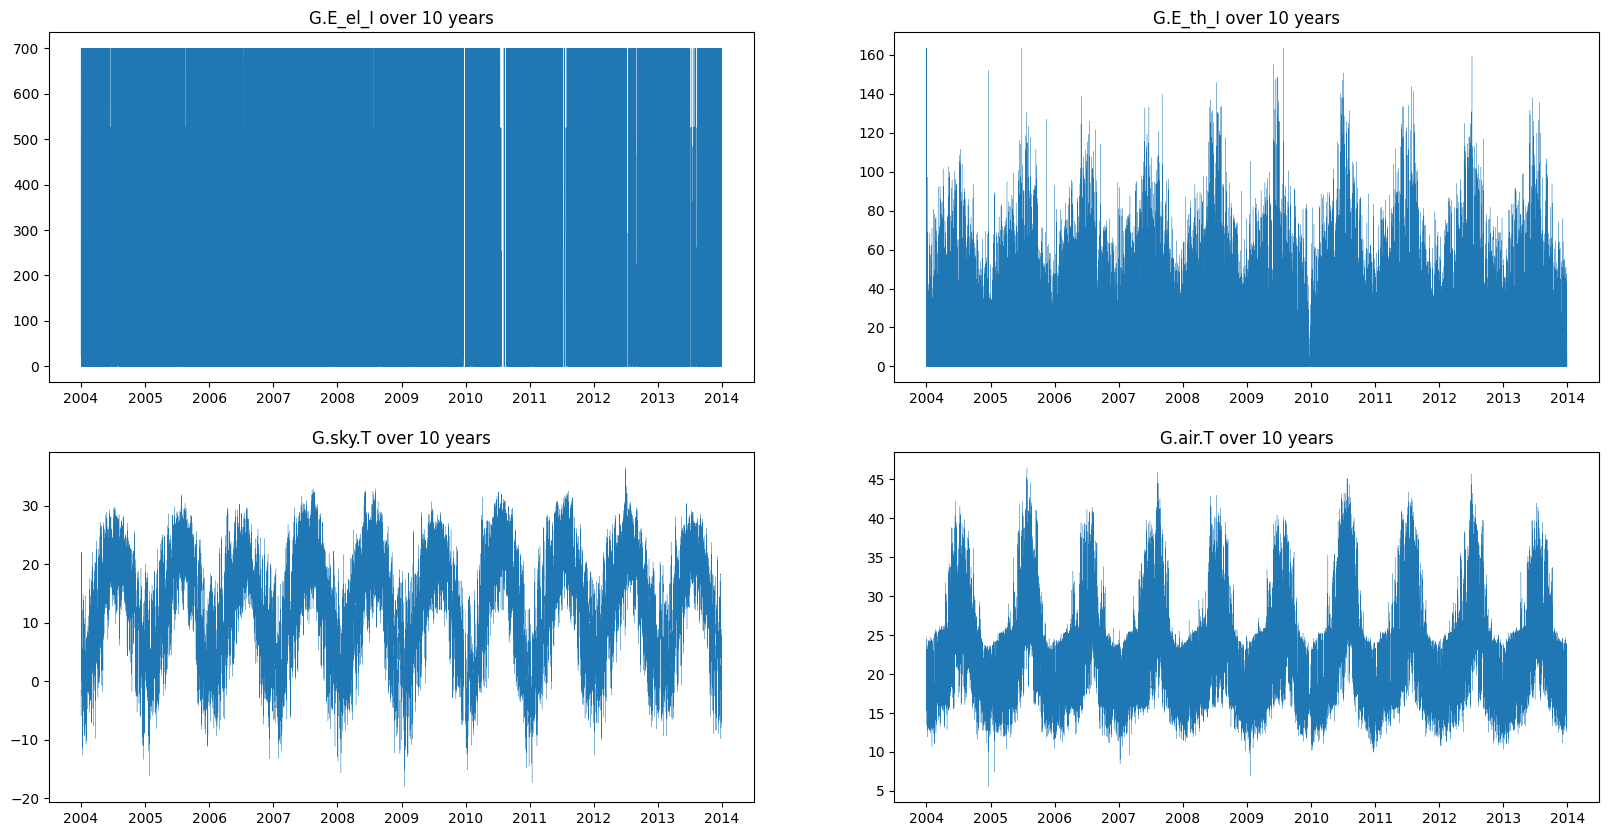

In [7]:
fig, ax = plt.subplots(2,2,figsize=(20,10))
ax[0,0].plot(base_data['G.E_el_I'], linewidth=0.2)
ax[0,0].set_title('G.E_el_I over 10 years')
ax[0,1].plot(base_data['G.E_th_I'], linewidth=0.2)
ax[0,1].set_title('G.E_th_I over 10 years')
ax[1,0].plot(base_data['G.sky.T'], linewidth=0.2)
ax[1,0].set_title('G.sky.T over 10 years')
ax[1,1].plot(base_data['G.air.T'], linewidth=0.2)
ax[1,1].set_title('G.air.T over 10 years')

plt.show()

In [7]:
base_data.columns

Index(['G.air.T', 'G.sky.T', 'G.E_el_I', 'G.E_th_I', 'hour', 'day_of_week',
       'month', 'season'],
      dtype='object')

<h3> Test train splitting </h3>

In [8]:
end_train = base_data.index.max() - pd.DateOffset(years=1)

base_data_train = base_data.loc[:end_train, :].copy()
base_data_test  = base_data.loc[end_train:, :].copy()
print(base_data_train.shape, base_data_test.shape)

(78841, 8) (8761, 8)


<h3> Subsampling with rolling window </h3>

In [9]:
def create_rolling_windows(df, window_size, stride):
    windows = []
    for start in range(0, len(df) - window_size + 1, stride):
        end = start + window_size
        window = df.iloc[start:end]
        
        windows.append(window)
    return np.array(windows)

In [10]:
window, step = 365*2, 365*2

sampled_base_data = (create_rolling_windows(base_data_train, window, step), create_rolling_windows(base_data_test, window, step))

print(sampled_base_data[0].shape, sampled_base_data[1].shape)
print(f'''Created {sampled_base_data[0].shape[0]} training samples of length {sampled_base_data[0].shape[1]}
and {sampled_base_data[1].shape[0]} testing samples of length {sampled_base_data[1].shape[1]}''')

(108, 730, 8) (12, 730, 8)
Created 108 training samples of length 730
and 12 testing samples of length 730


In [11]:
np.save('../../data/training_data/training_data_1month.npy', sampled_base_data)

/opt/anaconda3/lib/python3.10/site-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


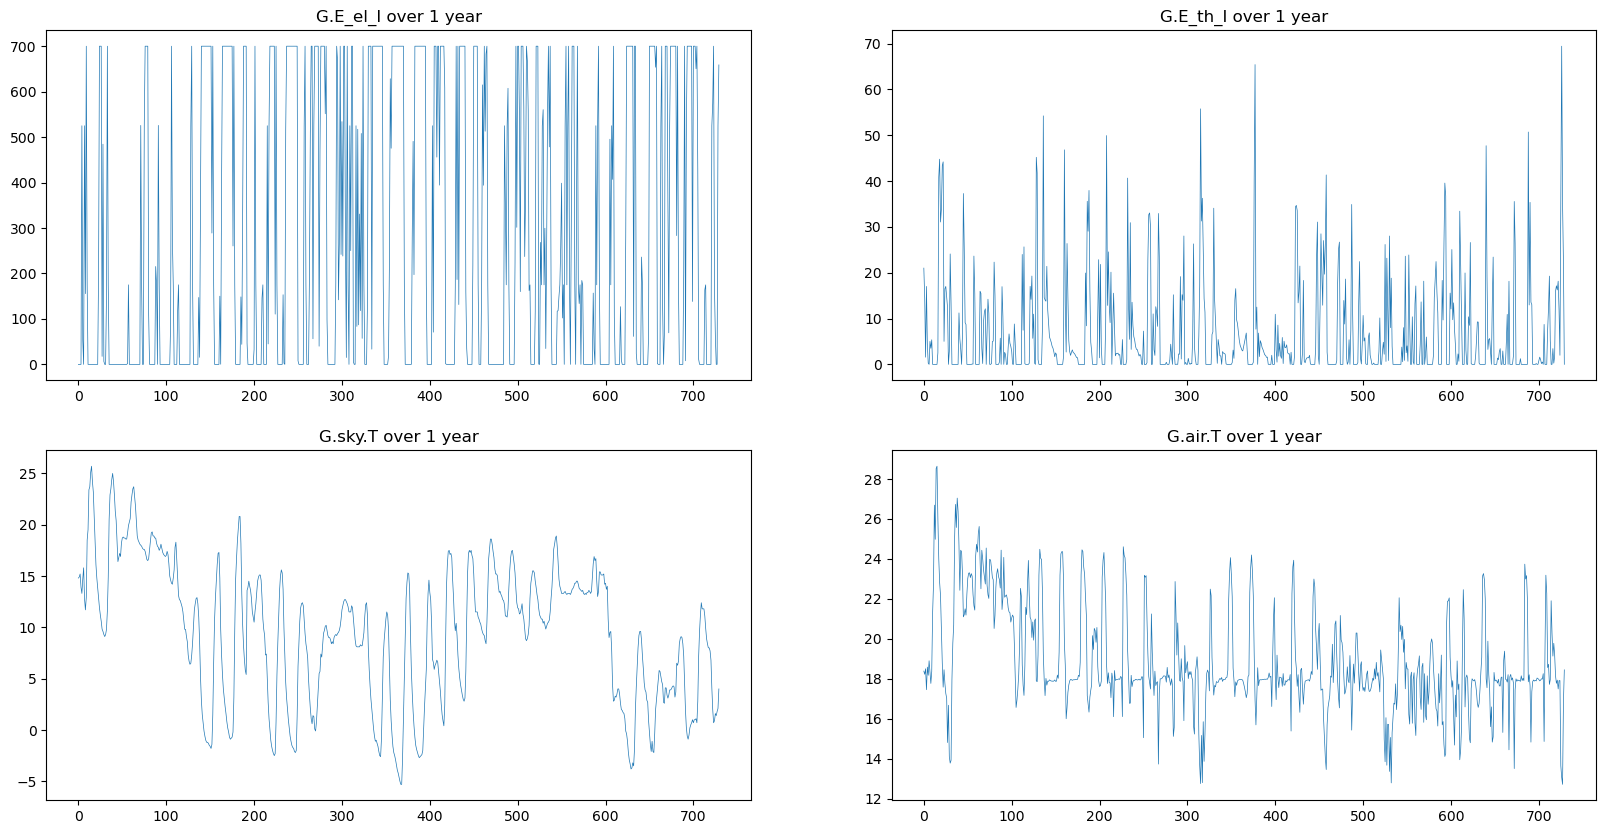

In [12]:
sampled_base_datum = pd.DataFrame(sampled_base_data[0][10], columns=base_data.columns)


fig, ax = plt.subplots(2,2,figsize=(20,10))

ax[0,0].plot(sampled_base_datum['G.E_el_I'], linewidth=0.5)
ax[0,0].set_title('G.E_el_I over 1 year')
ax[0,1].plot(sampled_base_datum['G.E_th_I'], linewidth=0.5)
ax[0,1].set_title('G.E_th_I over 1 year')
ax[1,0].plot(sampled_base_datum['G.sky.T'], linewidth=0.5)
ax[1,0].set_title('G.sky.T over 1 year')
ax[1,1].plot(sampled_base_datum['G.air.T'], linewidth=0.5)
ax[1,1].set_title('G.air.T over 1 year')


plt.show()